# Jupyter notebook sample

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import y_pred
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
insurance = pd.read_csv('insurance.csv')

In [3]:
print(insurance.shape)

ProfileReport(insurance)


(1338, 7)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

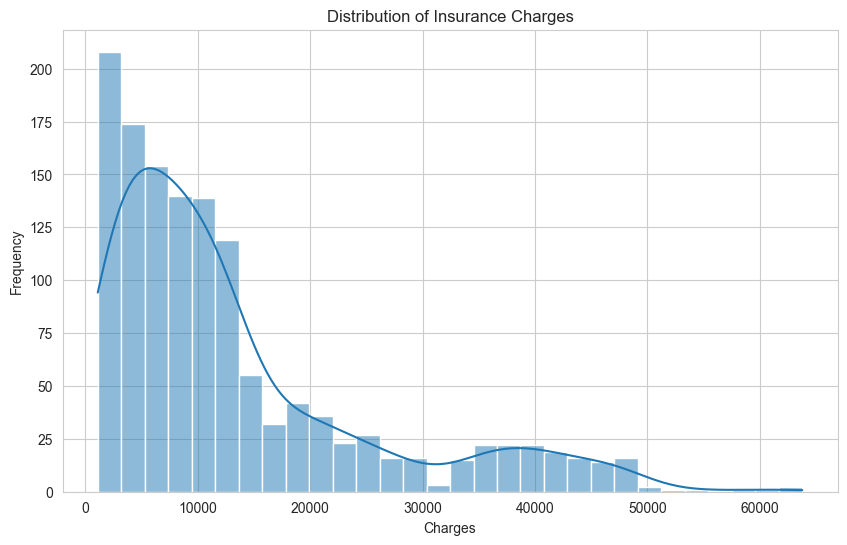

In [4]:
# Plot histogram of 'charges' column
plt.figure(figsize=(10, 6))
sns.histplot(insurance['charges'], bins="auto", kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

Since there's a lot of charges spread across several orders of magnitude, and the distribution is centred around zero, we'll need to transform the distribution

In [5]:
# Check for missing values in the dataframe
missing_values = insurance.isnull().sum()
print(missing_values)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
print(insurance.dtypes)
print(insurance.nunique())

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


Initial exploration indicates no missing data and data types for gender, smoking, and region only have 2, 2, and 4 values, respectively


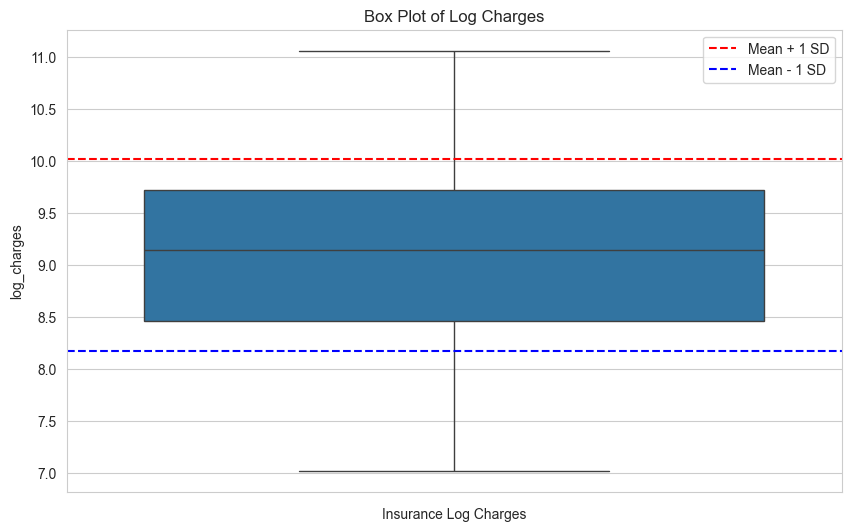

In [62]:
# Convert categorical columns to numerical on a copy of the dataframe
insurance_copy = insurance.copy()

# Apply logarithmic transformation to the 'charges' column
insurance_copy['log_charges'] = np.log1p(insurance_copy['charges'])

# Dummy variables for later
insurance_copy = pd.get_dummies(insurance_copy, columns=['sex', 'smoker', 'region'], drop_first=True)

# Plot a box plot of 'log_charges'
plt.figure(figsize=(10, 6))
sns.boxplot(y=insurance_copy['log_charges'])
plt.title('Box Plot of Log Charges')

# Calculate standard deviation and mean
log_charges_std = insurance_copy['log_charges'].std()
log_charges_mean = insurance_copy['log_charges'].mean()

# Add lines for the standard deviation
plt.axhline(log_charges_mean + log_charges_std, color='r', linestyle='--', label='Mean + 1 SD')
plt.axhline(log_charges_mean - log_charges_std, color='b', linestyle='--', label='Mean - 1 SD')
plt.xlabel('Insurance Log Charges')
plt.legend()
plt.show()

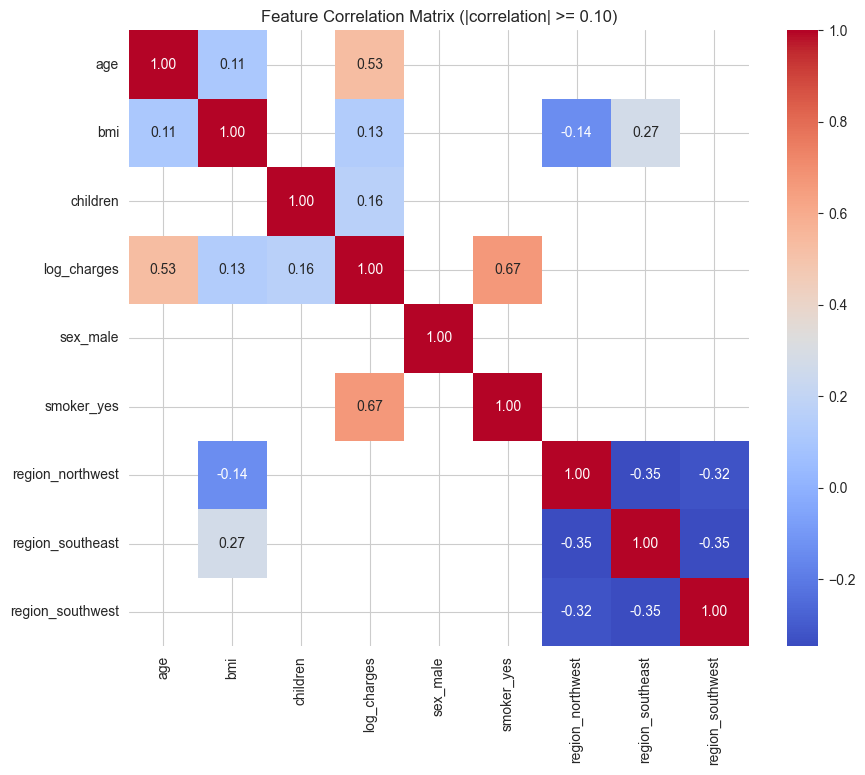

In [64]:
# Check the correlation of the copy of the dataframe, excluding 'charges'
correlation_matrix = insurance_copy.drop(columns=['charges']).corr()

# Filter correlations to only include those with abs value >= 0.10
filtered_correlation_matrix = correlation_matrix.where(correlation_matrix.abs() >= 0.10)

# Use Seaborn to plot the filtered correlations as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix (|correlation| >= 0.10)')
plt.show()

The strongest correlation by far is the smokers, followed by age, then people from the southeast region having a high BMI

In [65]:
# Get the top 10 highest correlations, excluding self-correlations and those related to region comparisons
correlation_matrix_unstacked = correlation_matrix.abs().unstack().sort_values(ascending=False)
correlation_filtered = correlation_matrix_unstacked[correlation_matrix_unstacked < 1].drop_duplicates()

# Exclude correlations between region columns
correlation_filtered = correlation_filtered[
    ~correlation_filtered.index.map(lambda x: 'region_' in x[0] and 'region_' in x[1])]

# Get the top 10 correlations after filtering
top_10_correlations = correlation_filtered.head(10)
print(top_10_correlations)

log_charges       smoker_yes          0.665539
                  age                 0.527807
region_southeast  bmi                 0.270025
children          log_charges         0.161317
bmi               region_northwest    0.135996
log_charges       bmi                 0.132678
age               bmi                 0.109272
smoker_yes        sex_male            0.076185
                  region_southeast    0.068498
bmi               sex_male            0.046371
dtype: float64


# Initial analysis
Smokers have very high correlation with charges, age is the next one, followed by bmi, and people from the southeast region


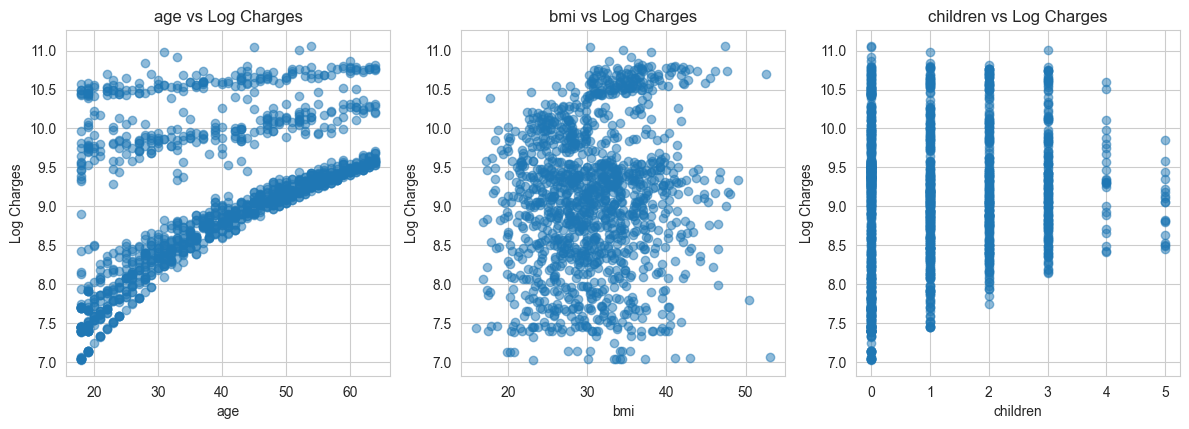

In [68]:
# Plot all numeric columns against 'log_charges'
numeric_columns = insurance_copy.select_dtypes(include=['int64', 'float64']).columns.drop(['charges', 'log_charges'])

plt.figure(figsize=(12, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    plt.scatter(insurance_copy[column], insurance_copy['log_charges'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Log Charges')
    plt.title(f'{column} vs Log Charges')

plt.tight_layout()
plt.show()

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'sex_male',
       'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'],
      dtype='object')


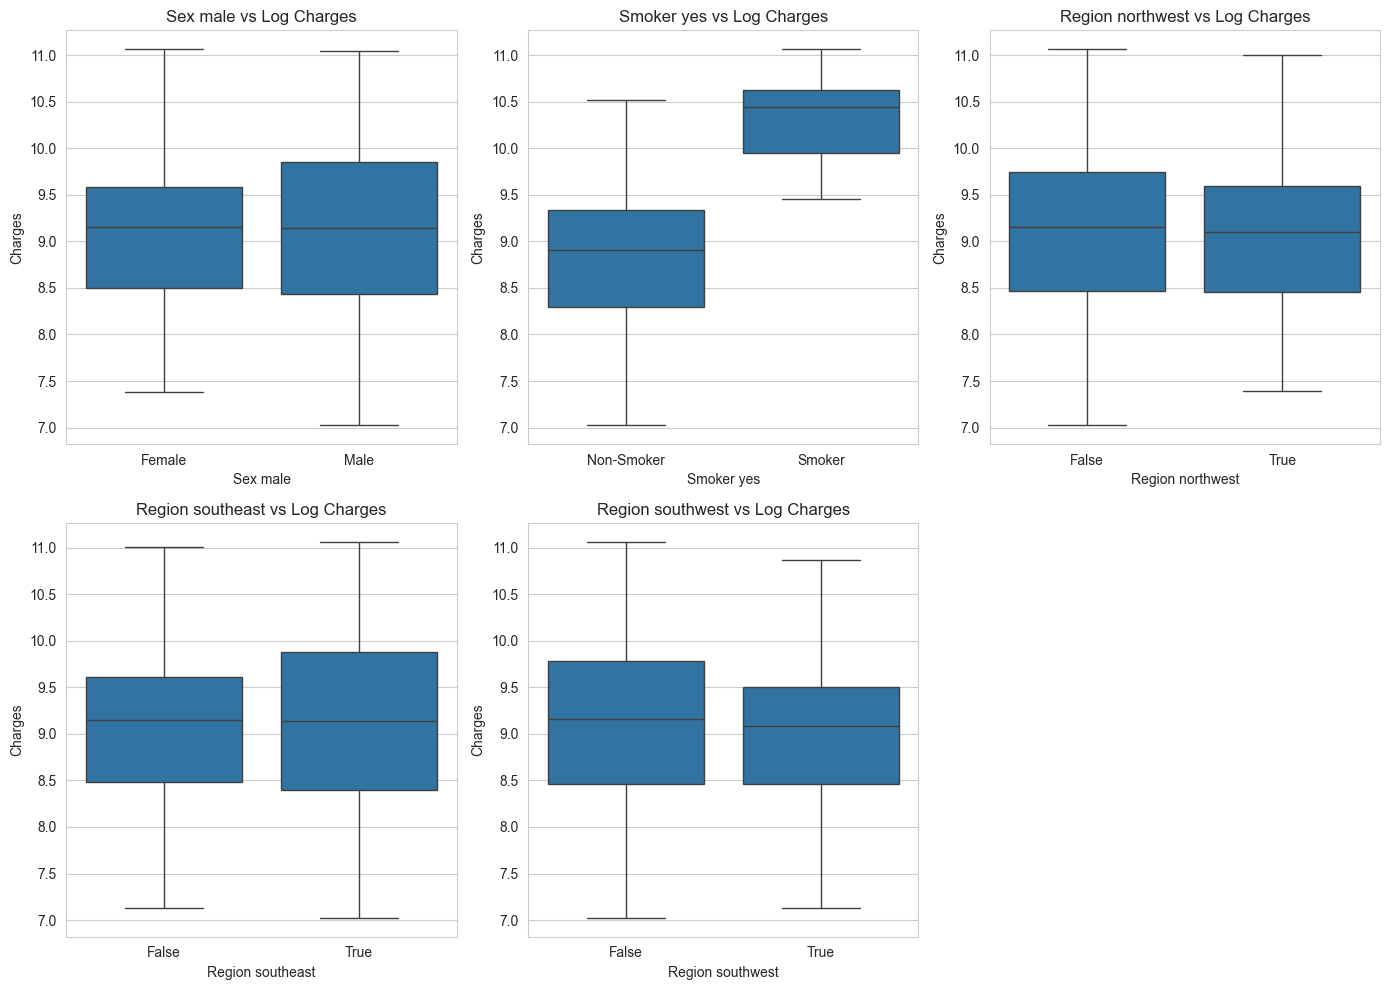

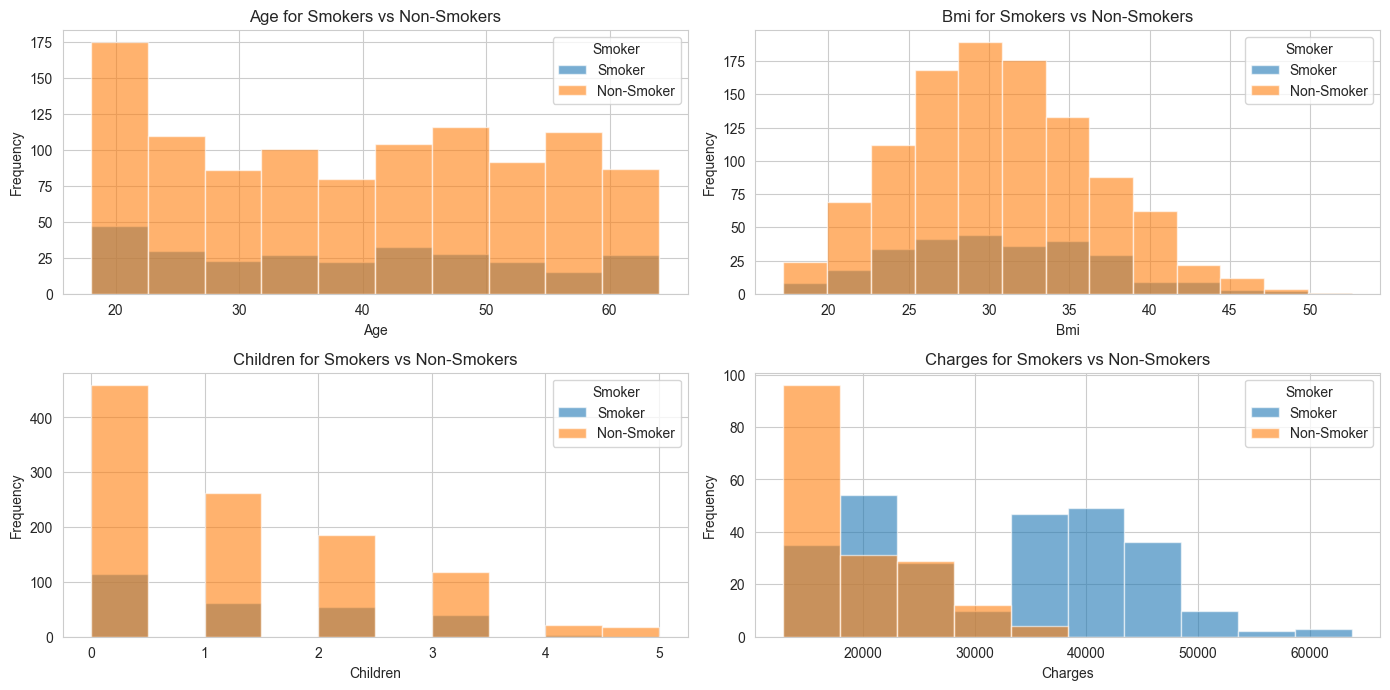

In [75]:
# Plot boxplots of categorical features against 'charges'
categorical_columns = ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

# Print dummy column names created for categorical variables
print(insurance_copy.columns)

plt.figure(figsize=(14, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)  # Adjusting subplot dimensions to match column count
    if column == 'sex_male':
        labels = ['Female', 'Male']
    elif column == 'smoker_yes':
        labels = ['Non-Smoker', 'Smoker']
    else:
        labels = None

    sns.boxplot(x=insurance_copy[column], y=insurance_copy['log_charges'])
    plt.title(f'{column.capitalize().replace("_", " ")} vs Log Charges')
    plt.xlabel(column.capitalize().replace("_", " "))
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.ylabel('Charges')

plt.tight_layout()
plt.show()

# Plot histograms of numeric features stratified by 'smoker' against 'charges'
numeric_columns = insurance_copy.select_dtypes(include=['int64', 'float64']).columns.drop('log_charges')

plt.figure(figsize=(14, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    bins_number = None  # assuming 'auto' provides a consistent bin number; otherwise, set a specific number
    for j, val in enumerate(insurance_copy['smoker_yes'].unique()):
        subset = insurance_copy[insurance_copy['smoker_yes'] == val]
        label = 'Smoker' if val == 1 else 'Non-Smoker'
        if bins_number is None:
            count, bins_number, _ = plt.hist(subset[column], bins='auto', alpha=0.6, label=label)
        else:
            plt.hist(subset[column], bins=bins_number, alpha=0.6, label=label)
    plt.title(f'{column.capitalize()} for Smokers vs Non-Smokers')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.legend(title='Smoker')

plt.tight_layout()
plt.show()

# Analysis
The distributions of children, age and BMI for smokers seem to be similar enough to the non smoking population, but the charges are substantially higher for Smokers

# Data split
**age**, **bmi** and **smoker** are positively correlated with increased charges so are good starting candidate predictors for the final modle


In [20]:
# split data
X = insurance_copy[['age', 'bmi', 'smoker_yes']]
y = insurance_copy['log_charges']

# We'll train on 2/3rds of the of dataset to start
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)
y_pred = insurance_model.predict(X_train)
print(f'Training R^2: {r2_score(y_train, y_pred):.2f}')
print(f'Training MSE: {np.exp(mean_squared_error(y_train, y_pred)):.2f}')

Training R^2: 0.74
Training MSE: 1.57


R2 is 0.74 and MSE is 1.57 a good starting point but there's more to try

In [76]:
# Print model coefficients and intercept
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': insurance_model.coef_})
intercept = insurance_model.intercept_
print(coefficients)
print(f'Intercept: {intercept:.2f}')

      Feature  Coefficient
0         age     0.050694
1         bmi     0.015771
2  smoker_yes     2.252353
Intercept: 10.20


This indicates the model is primarily driven by the smoking status. An unsurprising result, but not exactly helpful. Most people already know smokers incur higher healthcare costs. An intercept predicts the expected charges for someone of no age, non-smoking, and no BMI.

No BMI doesn't make sense, so the intercept doesn't have an interpretable value. We could potentially apply a scaler to BMI, we'd need to be careful about picking minimum and maximum values,

# Residual

Let's look at the residuals vs the predictions. It should be pretty linear


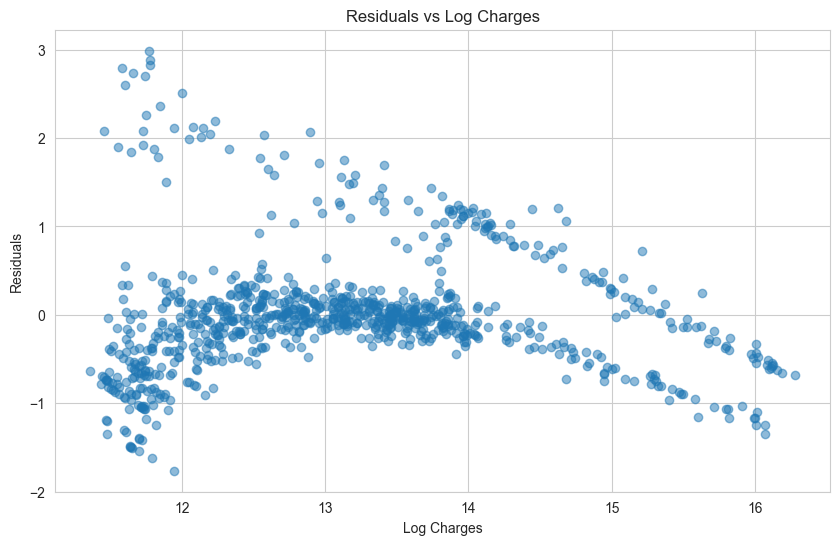

In [78]:
# Calculate the residuals
residuals = y_train - y_pred
# Create a DataFrame to store residuals and predictions
test_df = pd.DataFrame({'True Values': y_train, 'Log Charges': y_pred, 'Residuals': residuals})

# Plot residuals vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_df['Log Charges'], test_df['Residuals'], alpha=0.5)
plt.title('Residuals vs Log Charges')
plt.xlabel('Log Charges')
plt.ylabel('Residuals')
plt.show()

The assumption of linearity does not hold. As fitted values get larger, the value of the residuals trends downwards, at low charge values, the residuals vary more, there's multiple bands

# Model evaluation

Let's see how the model performs on the test set of data.

In [28]:
test_pred = insurance_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
print(test_mse)


0.4454023486902183


In [29]:
np.exp(test_mse)

np.float64(1.5611181833455634)

The training and test MSE are 1.57 and 1.56, suggesting the model is not cover fit. The model is not very accurate though. Let's try a few more things to make it a bit more complicated


In [41]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Define the range of polynomial degrees you want to try
degrees = [1, 2, 3, 4, 5]

# Define the options for include_bias
bias_options = [True, False]

# Create a list to store results
results = []

# Loop through each bias option and polynomial degree
for include_bias in bias_options:
    for degree in degrees:
        # Create a pipeline that first creates polynomial features and then fits a linear regression model
        polynomial_pipeline = Pipeline([
                ('poly_features', PolynomialFeatures(degree=degree, include_bias=include_bias)),
                ('linear_regression', LinearRegression())
        ]
        )

        # Fit the polynomial model
        polynomial_pipeline.fit(X_train, y_train)

        # Make predictions on the training data
        y_train_pred = polynomial_pipeline.predict(X_train)

        # Evaluate the model on training data
        train_r2 = r2_score(y_train, y_train_pred)
        train_mse = np.exp(mean_squared_error(y_train, y_train_pred))

        # Make predictions on the test data
        y_test_pred = polynomial_pipeline.predict(X_test)

        # Evaluate the model on test data
        test_r2 = r2_score(y_test, y_test_pred)
        test_mse = np.exp(mean_squared_error(y_test, y_test_pred))

        # Calculate the delta between training and test MSE
        mse_delta = test_mse - train_mse

        # Append results to the list
        results.append({
                'Include Bias'     : include_bias,
                'Polynomial Degree': degree,
                'Training R^2'     : train_r2,
                'Training MSE'     : train_mse,
                'Test R^2'         : test_r2,
                'Test MSE'         : test_mse,
                'MSE Delta'        : mse_delta
        }
        )

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results as a pretty table
results_df.style.format({
        'Training R^2': "{:.2f}",
        'Training MSE': "{:.2f}",
        'Test R^2'    : "{:.2f}",
        'Test MSE'    : "{:.2f}",
        'MSE Delta'   : "{:.2f}"
}
).background_gradient(cmap='viridis', subset=['Training MSE', 'Test MSE', 'MSE Delta'])

,Include Bias,Polynomial Degree,Training R^2,Training MSE,Test R^2,Test MSE,MSE Delta
0,True,1,0.74,1.57,0.74,1.56,-0.01
1,True,2,0.81,1.40,0.80,1.42,0.02
2,True,3,0.81,1.39,0.80,1.42,0.03
3,True,4,0.82,1.38,0.80,1.42,0.04
4,True,5,0.82,1.38,0.80,1.43,0.05
5,False,1,0.74,1.57,0.74,1.56,-0.01
6,False,2,0.81,1.40,0.80,1.42,0.02
7,False,3,0.81,1.39,0.80,1.42,0.03
8,False,4,0.82,1.38,0.80,1.42,0.04
9,False,5,0.82,1.38,0.80,1.43,0.05


Moving to a second order polynomial at least gets to a better R^2, but at the cost of slightly worse delta between the mean squared error


Number of rows removed: 142
(1196, 9)


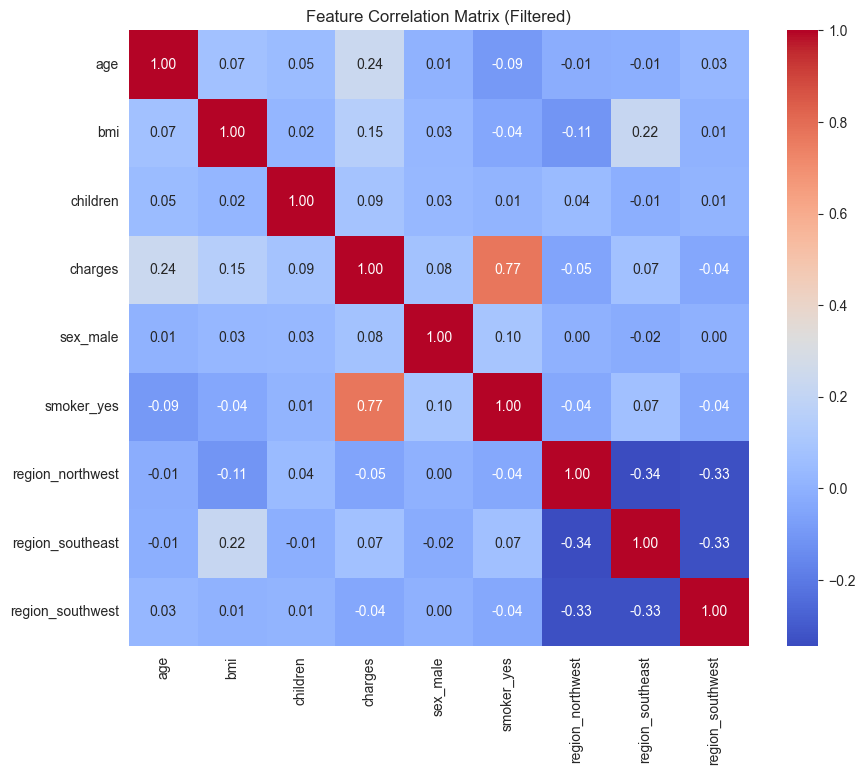

Training R^2 (Filtered): 0.75
Training MSE (Filtered): 1.20


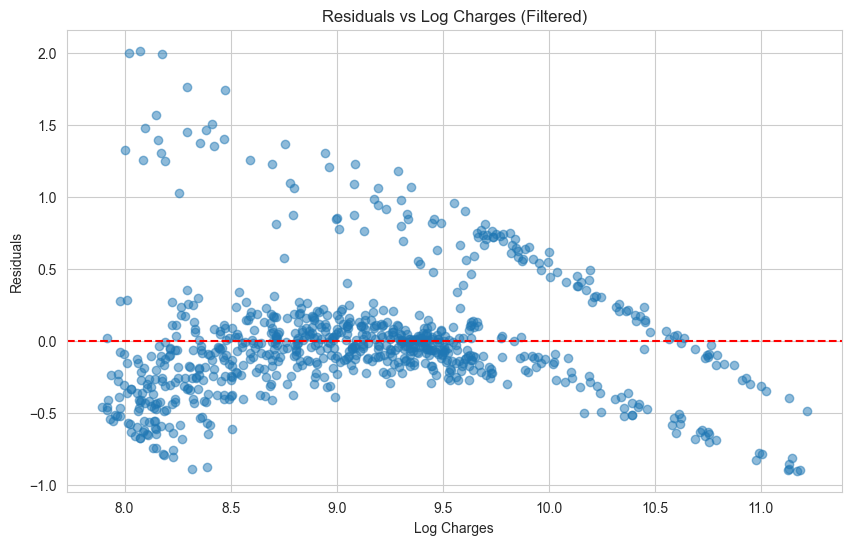

In [44]:
# Removing top and bottom 2% outliers for each numeric column
def remove_outliers(df, columns, percent=0.02):
    original_size = df.shape[0]
    for column in columns:
        lower_bound = df[column].quantile(percent)
        upper_bound = df[column].quantile(1 - percent)
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    removed_rows = original_size - df.shape[0]
    print(f'Number of rows removed: {removed_rows}')
    return df


numeric_columns = insurance.select_dtypes(include=['int64', 'float64']).columns
insurance_filtered = remove_outliers(insurance, numeric_columns)

# Perform one-hot encoding to handle categorical variables
insurance_filtered = pd.get_dummies(insurance_filtered, drop_first=True)

# Check the shape after outlier removal and encoding
print(insurance_filtered.shape)

# Recompute correlation matrix on the filtered data
correlation_matrix_filtered = insurance_filtered.corr()

# Use Seaborn to plot the filtered correlations as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix (Filtered)')
plt.show()

# Proceeding with the training of the model on the filtered and encoded data
X_filtered = insurance_filtered[['age', 'bmi', 'smoker_yes']]
y_filtered = np.log(insurance_filtered['charges'])  # Assuming log transformation was intended

# We'll train on 2/3rds of the dataset to start
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered,
                                                                                        test_size=0.33, random_state=42
                                                                                        )

insurance_model_filtered = LinearRegression()
insurance_model_filtered.fit(X_train_filtered, y_train_filtered)
y_train_pred_filtered = insurance_model_filtered.predict(X_train_filtered)
print(f'Training R^2 (Filtered): {r2_score(y_train_filtered, y_train_pred_filtered):.2f}')
print(f'Training MSE (Filtered): {np.exp(mean_squared_error(y_train_filtered, y_train_pred_filtered)):.2f}')

# Calculate the residuals
residuals_filtered = y_train_filtered - y_train_pred_filtered
# Create a DataFrame to store residuals and predictions
test_df_filtered = pd.DataFrame(
    {'True Values': y_train_filtered, 'Log Charges': y_train_pred_filtered, 'Residuals': residuals_filtered}
)

# Plot residuals vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_df_filtered['Log Charges'], test_df_filtered['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Log Charges (Filtered)')
plt.xlabel('Log Charges')
plt.ylabel('Residuals')
plt.show()

# Conclusions
The MSE for training and test data were pretty similar, so model isn't overfit.
 The residuals indicate however lower costs for customers that were charged much higher.
 Suggesting some systematic error in the model.
 A polynomial fit did not improve the residuals.

It might be reasonable to segment observations into 2 or more data sets, low, and high charges and train two separate models